In [37]:
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from lensless.plot import plot_image
import numpy as np
import pandas as pd
from pprint import pprint

In [15]:
ds = datasets.CelebA(
    root="/home/bezzam/Desktop",
    split="test",
    download=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0,), (1,))]
    ),
)

In [16]:
# print dataset info
print(f"Number of files : {len(ds)}")
iden = np.unique(ds.identity.numpy())
print(f"Unique identities : {len(iden)}")
print(f"Attributes : {ds.attr_names}")

Number of files : 19962
Unique identities : 1000
Attributes : ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', '']


In [81]:
interesting_metadata = ["Male", "Smiling", "Eyeglasses", "Young"]
metadata_idx = []
for i, _val in enumerate(ds.attr_names):
    if _val in interesting_metadata:
        metadata_idx.append(i)
print(metadata_idx)

[15, 20, 31, 39]


# plot an image

Shape : torch.Size([3, 218, 178])
Maximum value : 1.0
Minimum value : 0.0

METADATA
{'Eyeglasses': 0, 'Male': 0, 'Smiling': 1, 'Young': 0}


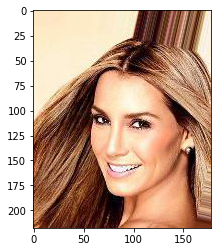

In [94]:
# plot an image
idx = 0
gamma = 1
normalize_plot = True

img, labels = ds[idx]
print(f"Shape : {img.shape}")
print(f"Maximum value : {img.max()}")
print(f"Minimum value : {img.min()}")
input_image_cpu = np.transpose(img.cpu(), (1, 2, 0))
plot_image(input_image_cpu, gamma=gamma, normalize=normalize_plot)

print("\nMETADATA")
metadata_dict = {}
for i in metadata_idx:
    metadata_dict[ds.attr_names[i]] = labels[i].item()
pprint(metadata_dict)

# metadata distribution
https://pytorch.org/vision/main/_modules/torchvision/datasets/celeba.html#CelebA

In [85]:
interesting_metadata

['Male', 'Smiling', 'Eyeglasses', 'Young']

In [96]:
attr = pd.DataFrame(ds.attr[:, metadata_idx], columns = interesting_metadata)
attr["identity"] = ds.identity.numpy()
print(attr.shape)


(19962, 5)


In [97]:
attr.head()

,Male,Smiling,Eyeglasses,Young,identity
0,0,0,1,0,7760
1,0,0,0,1,7988
2,0,0,1,1,5858
3,0,0,1,1,4930
4,0,0,1,1,6192


In [98]:
attr["Smiling"].value_counts()

0    12247
1     7715
Name: Smiling, dtype: int64

In [99]:
attr["Male"].value_counts()

0    18673
1     1289
Name: Male, dtype: int64

In [100]:
attr["identity"].value_counts()

9256    32
4978    31
7760    30
4992    30
6657    30
        ..
5992     2
6584     2
7778     1
8585     1
8565     1
Name: identity, Length: 1000, dtype: int64